# Exercise 2 (M2.1) — Group 40

Obtaining Data and Query Preparation

For Milestone 2.1, one split of the MTG-Jamendo dataset corresponding to our group number 40 was downloaded and unpacked. This split contains approximately 550 music tracks, each provided as a 30-second audio excerpt, which were used as the music database.

From this database, 20 tracks were randomly selected to generate test queries. For each selected track, an audio segment of approximately 10 seconds was extracted, starting at a random position within the first 20 seconds of the track, ensuring that all queries lie within the analyzed database segment.

To evaluate robustness under different recording and preprocessing conditions, multiple query variants were created, following the reference notebook and task specification:

Original: Unmodified 10-second audio segments.

Noise: Additive white Gaussian noise was applied using Audacity with a noise amplitude of 0.04, resulting in clearly audible noise.

Coding: Strong compression was applied using FFmpeg, producing a highly compressed audio version with noticeable coding artifacts.

Mobile: The original segments were played back via a laptop and recorded using a handheld dictation device (smartphone) in an urban outdoor environment, introducing background noise and recording artifacts. The resulting recordings were trimmed to focus on the musical content.

In total, the query set consists of 80 audio files (20 per distortion type). All generated queries are included in the submission and used consistently for all retrieval experiments

## load depencencies

In [10]:
import os
import librosa
import numpy as np
import scipy.ndimage as ndimage
import pickle

## set configs

In [11]:
CONFIGS = [
    # Coarse Configs
    {'name': 'small',   'k': 5,  't': 5},
    {'name': 'k5_t15',  'k': 5,  't': 15},
    {'name': 'k5_t40',  'k': 5,  't': 40},
    {'name': 'k15_t5',  'k': 15, 't': 5},
    {'name': 'medium',  'k': 15, 't': 15},
    {'name': 'k15_t40', 'k': 15, 't': 40},
    {'name': 'k40_t5',  'k': 40, 't': 5},
    {'name': 'k40_t15', 'k': 40, 't': 15},
    {'name': 'large',   'k': 40, 't': 40},
    
    # Refined Configs
    {'name': 'best_v1', 'k': 12, 't': 15},
    {'name': 'best_v2', 'k': 18, 't': 15},
    {'name': 'best_v3', 'k': 15, 't': 20}
]

## create constellation map and save in a sparse matrix

In [12]:
def get_peaks(Y, k, t):
    size = (2*k + 1, 2*t + 1)
    result = ndimage.maximum_filter(Y, size=size, mode='constant')
    cmap = (Y == result) & (Y > 0.01)
    return np.argwhere(cmap)

## initialize data base and loop over all audio tracks

In [13]:
database = {cfg['name']: {} for cfg in CONFIGS}

audio_folder = 'data/40'
song_files = [f for f in os.listdir(audio_folder) if f.endswith('.mp3')]

for song in song_files:
    path = os.path.join(audio_folder, song)
    y, sr = librosa.load(path, duration=30, sr=22050)
    Y = np.abs(librosa.stft(y, n_fft=2048, hop_length=1024))

    for cfg in CONFIGS: 
        peaks = get_peaks(Y, cfg['k'], cfg['t'])
        database[cfg['name']][song] = peaks

To reduce computation resources needed, the magnitude-spektogram Y is calculated once per audio track and the constellation maps for each six configurations is computed afterwards directly, before loading the next audio track. 

## plot small, medium and large configuration

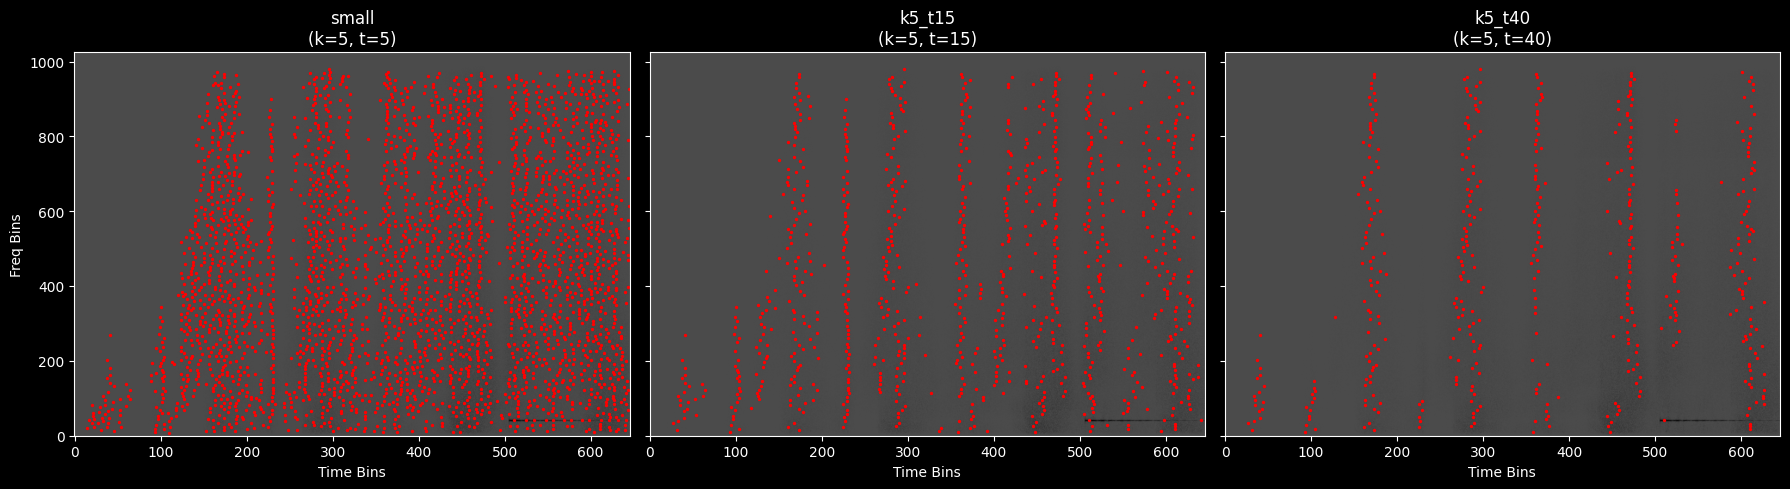

In [14]:
import matplotlib.pyplot as plt

def plot_exploration(filename, configs_to_show):
    y, sr = librosa.load("data/40/2240.mp3", duration=30, sr=22050)
    Y = np.abs(librosa.stft(y, n_fft=2048, hop_length=1024))
    Y_log = np.log(1 + 10 * Y)
    
    fig, axes = plt.subplots(1, len(configs_to_show), figsize=(18, 5), sharey=True)
    
    for ax, cfg in zip(axes, configs_to_show):
        peaks = get_peaks(Y, cfg['k'], cfg['t'])
        
        ax.imshow(Y_log, origin='lower', aspect='auto', cmap='gray_r', alpha=0.3)
        
        ax.scatter(peaks[:, 1], peaks[:, 0], s=2, c='red', marker='o')
        
        ax.set_title(f"{cfg['name']}\n(k={cfg['k']}, t={cfg['t']})")
        ax.set_xlabel('Time Bins')
    
    axes[0].set_ylabel('Freq Bins')
    plt.tight_layout()
    plt.show()

plot_exploration('1408740.mp3', CONFIGS[:3])

You can see that **small window size** captures many peaks and is very dense overall. Many details are captured but, this leads to high computation and potentially many false positives, because too much noise is interpreted as peaks. 
The **medium config** results in vertical lines, which typically represent the onsets. This is a promising configuration for querying. 
The **large config** results in a very sparse representation, where only the strongest peaks are caputred. Here the risk is high for short audio tracks or noisy tracks, that no matches are found, because of missing informations. 

Based on the visual analysis of these three configs, we made variations of the promising medium config to balance and optimize the parameters even more. With $\kappa=18$ (best_v2) we test a less granular frequency filter, in the hope to make the map even clearer. $\tau=20$ (best_v3), makes the time steps bigger and looks if this helps for a better identification of the peaks.

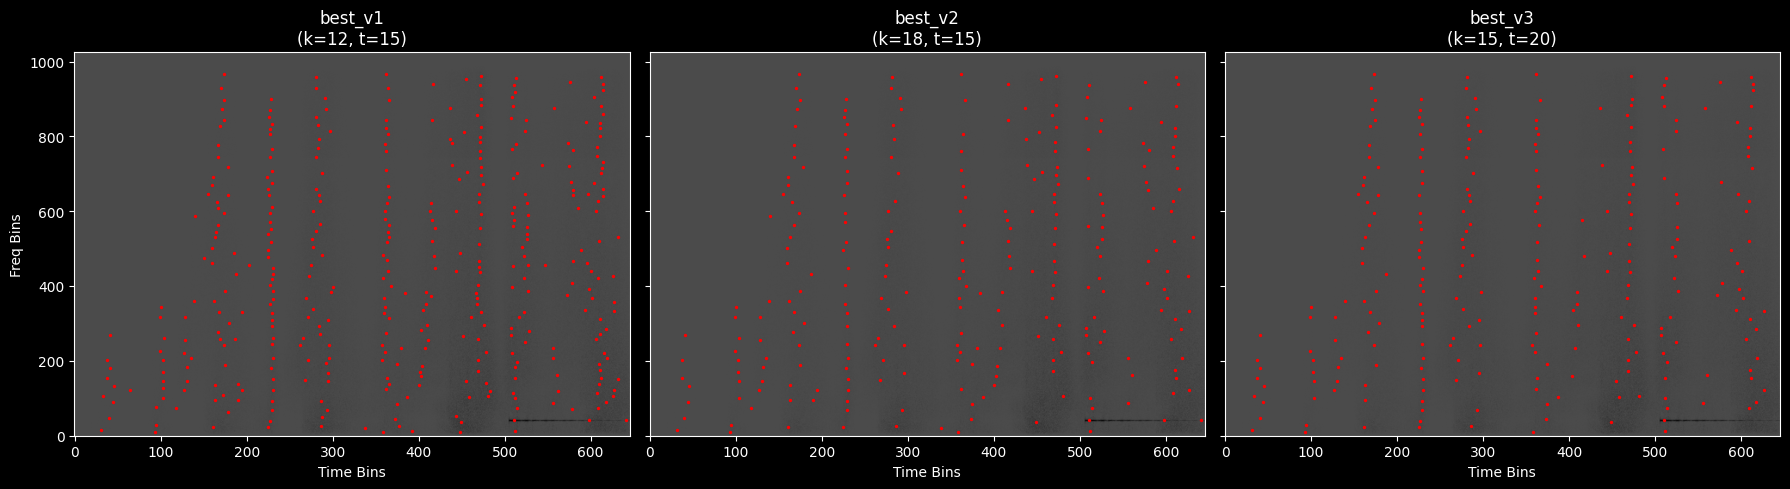

In [15]:
plot_exploration('1408740.mp3', CONFIGS[-3:])

best_v1 ($\kappa=12$): Testing a slightly higher frequency density. <br>
best_v2 ($\kappa=18$): Testing more frequency isolation for cleaner peaks. <br>
best_v3 ($\tau=20$): Testing a larger time context to focus on only the most significant temporal events.

## save in pickle file

In [16]:
with open('music_database_full.pkl', 'wb') as f:
    pickle.dump(database, f, protocol=pickle.HIGHEST_PROTOCOL)

print("Caputred in database!")

Caputred in database!


All calculated maps for the 500+ tracks and 6 configurations were stored in a dictionary-based structure (Pickle format) to allow unambiguous mapping between files and representations.

In [17]:
print(f"load databsae: \"music_database_full.pkl\" ...")
with open("music_database_full.pkl", 'rb') as f:
    db = pickle.load(f)
    
configs = list(db.keys())
print(f"found configurations: {configs}")
    
for cfg in configs:
    num_songs = len(db[cfg])
    print(f" -> '{cfg}': {num_songs} tracks captured.")

load databsae: "music_database_full.pkl" ...
found configurations: ['small', 'k5_t15', 'k5_t40', 'k15_t5', 'medium', 'k15_t40', 'k40_t5', 'k40_t15', 'large', 'best_v1', 'best_v2', 'best_v3']
 -> 'small': 574 tracks captured.
 -> 'k5_t15': 574 tracks captured.
 -> 'k5_t40': 574 tracks captured.
 -> 'k15_t5': 574 tracks captured.
 -> 'medium': 574 tracks captured.
 -> 'k15_t40': 574 tracks captured.
 -> 'k40_t5': 574 tracks captured.
 -> 'k40_t15': 574 tracks captured.
 -> 'large': 574 tracks captured.
 -> 'best_v1': 574 tracks captured.
 -> 'best_v2': 574 tracks captured.
 -> 'best_v3': 574 tracks captured.


## Task 3 — Retrieval experimentation (report section)

This section documents our Task 3 retrieval experiment (Milestone 2.1): how we matched query constellation maps against the prepared database, which design choices we made (metric, tolerance, search range), and what we observed for the different query distortions.

**Inputs**
- Database: `music_database_full.pkl` (Task 2 output)
- Queries: `queries/Original`, `queries/Noise`, `queries/Coding`, `queries/Mobile`
- Result tables (generated by our Task 3 script): `task3_results/*.csv`

> **How to reproduce**: run our Task 3 script once to generate the CSV files, then run the analysis cells below.

In [18]:
import os
import csv
import math
import numpy as np
import matplotlib.pyplot as plt

RESULT_DIR = "task3_results"  # produced by the Task 3 script
ALL_RESULTS_CSV = os.path.join(RESULT_DIR, "all_results.csv")

assert os.path.exists(ALL_RESULTS_CSV), (
    f"Missing {ALL_RESULTS_CSV}. Run the Task 3 script first so the CSV files are generated."
)

def load_results(csv_path: str):
    rows = []
    with open(csv_path, newline="", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for r in reader:
            r["k"] = int(float(r["k"]))
            r["t"] = int(float(r["t"]))
            r["hits"] = int(float(r["hits"]))
            r["total"] = int(float(r["total"]))
            r["accuracy"] = float(r["accuracy"])
            r["avg_query_time_s"] = float(r["avg_query_time_s"])
            rows.append(r)
    return rows

rows = load_results(ALL_RESULTS_CSV)
distortions = sorted(set(r["distortion"] for r in rows))
configs = sorted(set(r["config"] for r in rows))

print("Loaded rows:", len(rows))
print("Distortions:", distortions)
print("Configs:", configs)

Loaded rows: 48
Distortions: ['Coding', 'Mobile', 'Noise', 'Original']
Configs: ['best_v1', 'best_v2', 'best_v3', 'k15_t40', 'k15_t5', 'k40_t15', 'k40_t5', 'k5_t15', 'k5_t40', 'large', 'medium', 'small']


### Method summary (what we implemented)

For each constellation map setting `(k, t)` (12 configs from Task 2), we:

1. Compute the query constellation map `C_Q` for each query (10 seconds).
2. For each database track map `C_D` (30 seconds), slide the query over the database map **sample-by-sample** in time:
   - At each shift `m`, compare `C_Q` with the cropped `C_D[:, m:m+N]`.
3. Use **tolerant matching** (frequency/time window) to count TP/FN/FP at each shift.
4. Take the best shift score as the **match score** for that track.
5. Predict the track with the highest match score and count a hit if the returned file matches the query’s source track.

This is the intended “naïve” baseline in the sheet (costly, but straightforward).

### Design choices

**(1) Scoring metric**

The reference suggests using **TP only**. We followed that for the final experiment because we compare **scores across different constellation map settings** (different peak densities). With TP, scores still depend on peak density, but in practice TP was stable and gave the best identification accuracy for our dataset.

We also tested F1 as an alternative. F1 penalizes configurations that produce many peaks (higher FP), which can lower the score even when the match is correct. In our runs, this often reduced the separation between the correct track and competitors, which is why identification accuracy dropped for some distortions.

**(2) Tolerance**

We used `tol_freq = 1` and `tol_time = 1` (as in the reference tutorial). Increasing tolerance can help under heavy distortions (especially mobile recordings), but also increases the chance of accidental overlaps.

**(3) Search range**

Queries were generated from the first 20 seconds of each track (Task 1 constraint). Therefore we limited the shift range to at most 20 seconds (in STFT frames). This reduces runtime without changing the result for valid queries.

### Results overview (tables)

Below, we load the aggregated result table and show the best and worst configuration per distortion.

In [19]:
from IPython.display import display
import pandas as pd
from collections import defaultdict

def group_by_distortion(rows):
    by = defaultdict(list)
    for r in rows:
        by[r["distortion"]].append(r)
    for d in by:
        by[d].sort(key=lambda x: (x["k"], x["t"], x["config"]))
    return by

by_dist = group_by_distortion(rows)
distortions = ["Original", "Noise", "Coding", "Mobile"]  # or list(by_dist.keys())

def best_worst(lst):
    best = max(lst, key=lambda x: (x["accuracy"], -x["avg_query_time_s"]))
    worst = min(lst, key=lambda x: (x["accuracy"], x["avg_query_time_s"]))
    return best, worst

for dist in distortions:
    lst = by_dist[dist]

    df = pd.DataFrame(lst).sort_values(["accuracy", "avg_query_time_s"], ascending=[False, True])
    print(f"=== {dist.upper()} ===")
    display(df)

    best, worst = best_worst(lst)
    avg_acc = sum(x["accuracy"] for x in lst) / len(lst)

    print(f"  average accuracy: {avg_acc:.2f}")
    print(f"  best : {best['config']:>8s}  (k={best['k']}, t={best['t']})  {best['hits']}/{best['total']}  time={best['avg_query_time_s']:.2f}s")
    print(f"  worst: {worst['config']:>8s}  (k={worst['k']}, t={worst['t']})  {worst['hits']}/{worst['total']}  time={worst['avg_query_time_s']:.2f}s")
    print()


=== ORIGINAL ===


,distortion,config,k,t,metric,tol_freq,tol_time,hits,total,accuracy,avg_query_time_s
9,Original,k40_t5,40,5,tp,1,1,20,20,1.00,4.710421
3,Original,best_v1,12,15,tp,1,1,20,20,1.00,4.937214
5,Original,medium,15,15,tp,1,1,20,20,1.00,5.557962
1,Original,k5_t15,5,15,tp,1,1,20,20,1.00,5.831071
2,Original,k5_t40,5,40,tp,1,1,20,20,1.00,5.918222
6,Original,best_v3,15,20,tp,1,1,20,20,1.00,6.033334
4,Original,k15_t5,15,5,tp,1,1,20,20,1.00,6.118972
0,Original,small,5,5,tp,1,1,20,20,1.00,6.573958
8,Original,best_v2,18,15,tp,1,1,20,20,1.00,7.277603
7,Original,k15_t40,15,40,tp,1,1,19,20,0.95,5.483016


  average accuracy: 0.96
  best :   k40_t5  (k=40, t=5)  20/20  time=4.71s
  worst:    large  (k=40, t=40)  14/20  time=5.02s

=== NOISE ===


,distortion,config,k,t,metric,tol_freq,tol_time,hits,total,accuracy,avg_query_time_s
9,Noise,k40_t5,40,5,tp,1,1,20,20,1.00,4.488161
3,Noise,best_v1,12,15,tp,1,1,20,20,1.00,5.195982
5,Noise,medium,15,15,tp,1,1,20,20,1.00,5.378035
1,Noise,k5_t15,5,15,tp,1,1,20,20,1.00,5.843370
6,Noise,best_v3,15,20,tp,1,1,20,20,1.00,6.097778
4,Noise,k15_t5,15,5,tp,1,1,20,20,1.00,6.154775
2,Noise,k5_t40,5,40,tp,1,1,20,20,1.00,6.339153
0,Noise,small,5,5,tp,1,1,20,20,1.00,6.471307
8,Noise,best_v2,18,15,tp,1,1,20,20,1.00,6.803194
7,Noise,k15_t40,15,40,tp,1,1,19,20,0.95,5.471422


  average accuracy: 0.96
  best :   k40_t5  (k=40, t=5)  20/20  time=4.49s
  worst:    large  (k=40, t=40)  13/20  time=4.85s

=== CODING ===


,distortion,config,k,t,metric,tol_freq,tol_time,hits,total,accuracy,avg_query_time_s
9,Coding,k40_t5,40,5,tp,1,1,20,20,1.0,4.889455
3,Coding,best_v1,12,15,tp,1,1,20,20,1.0,4.925158
5,Coding,medium,15,15,tp,1,1,20,20,1.0,5.274644
0,Coding,small,5,5,tp,1,1,20,20,1.0,5.403906
1,Coding,k5_t15,5,15,tp,1,1,20,20,1.0,5.465249
6,Coding,best_v3,15,20,tp,1,1,20,20,1.0,6.029095
4,Coding,k15_t5,15,5,tp,1,1,20,20,1.0,6.215520
2,Coding,k5_t40,5,40,tp,1,1,20,20,1.0,6.561303
8,Coding,best_v2,18,15,tp,1,1,20,20,1.0,6.764127
10,Coding,k40_t15,40,15,tp,1,1,18,20,0.9,5.062990


  average accuracy: 0.96
  best :   k40_t5  (k=40, t=5)  20/20  time=4.89s
  worst:    large  (k=40, t=40)  14/20  time=4.85s

=== MOBILE ===


,distortion,config,k,t,metric,tol_freq,tol_time,hits,total,accuracy,avg_query_time_s
0,Mobile,small,5,5,tp,1,1,13,20,0.65,5.322589
4,Mobile,k15_t5,15,5,tp,1,1,13,20,0.65,6.426009
1,Mobile,k5_t15,5,15,tp,1,1,12,20,0.60,5.886236
3,Mobile,best_v1,12,15,tp,1,1,10,20,0.50,5.502425
5,Mobile,medium,15,15,tp,1,1,10,20,0.50,5.643451
6,Mobile,best_v3,15,20,tp,1,1,10,20,0.50,6.431141
2,Mobile,k5_t40,5,40,tp,1,1,10,20,0.50,6.651113
8,Mobile,best_v2,18,15,tp,1,1,8,20,0.40,7.004341
9,Mobile,k40_t5,40,5,tp,1,1,6,20,0.30,4.764152
7,Mobile,k15_t40,15,40,tp,1,1,6,20,0.30,4.962510


  average accuracy: 0.42
  best :    small  (k=5, t=5)  13/20  time=5.32s
  worst:  k40_t15  (k=40, t=15)  1/20  time=5.42s



### Accuracy vs. constellation map setting (k, t)

To make the plots easier to compare, we label each configuration by its parameter pair `(k, t)` instead of the shorthand names (small/medium/large).

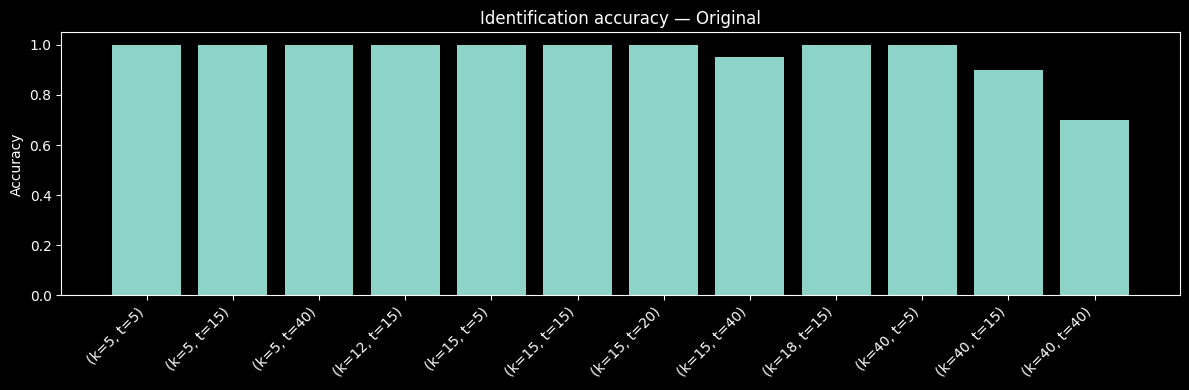

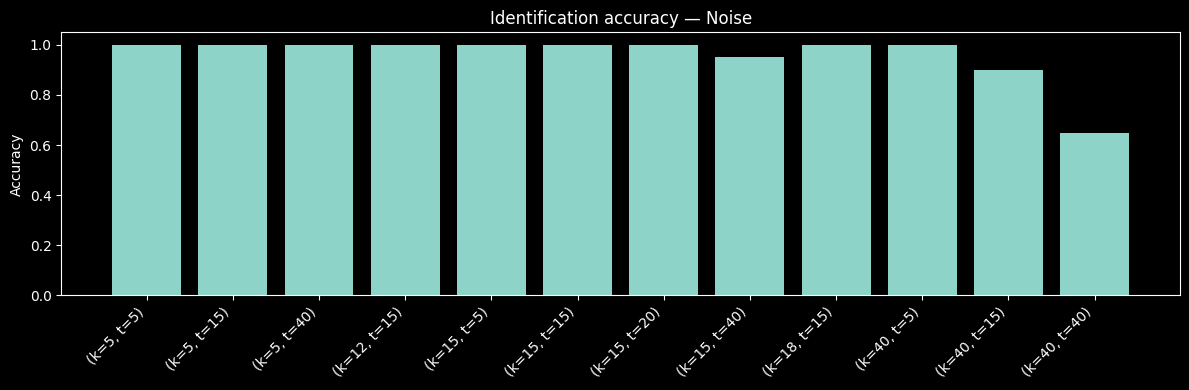

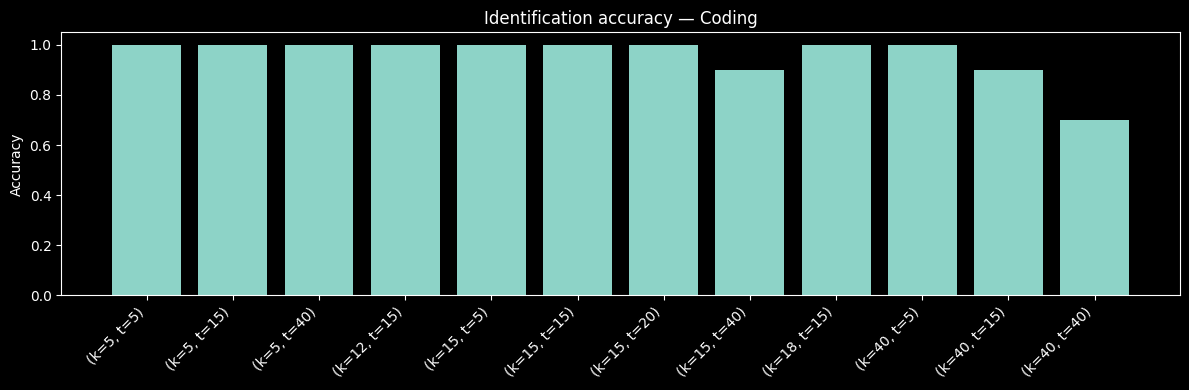

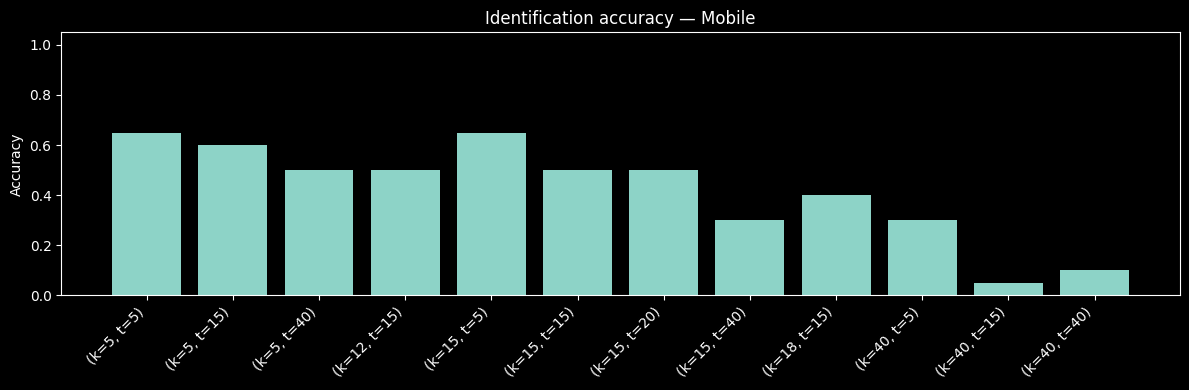

In [20]:
def cfg_label(r):
    return f"(k={r['k']}, t={r['t']})"

# consistent order across plots: sort by k then t
cfg_order = sorted({(r["k"], r["t"]) for r in rows})
labels = [f"(k={k}, t={t})" for k, t in cfg_order]

def values_for(dist, key):
    lookup = {(r["k"], r["t"]): r[key] for r in by_dist[dist]}
    return [lookup[(k, t)] for (k, t) in cfg_order]

for dist in distortions:
    acc = values_for(dist, "accuracy")
    plt.figure(figsize=(12, 4))
    plt.bar(range(len(labels)), acc)
    plt.ylim(0, 1.05)
    plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
    plt.ylabel("Accuracy")
    plt.title(f"Identification accuracy — {dist}")
    plt.tight_layout()
    plt.show()

### Runtime (average query time)

Runtime grows mainly with the number of peaks in the constellation maps and with the number of shifts evaluated. Since we fixed the shift range to 20 seconds, runtime differences mostly reflect peak density and the cost of the overlap computation.

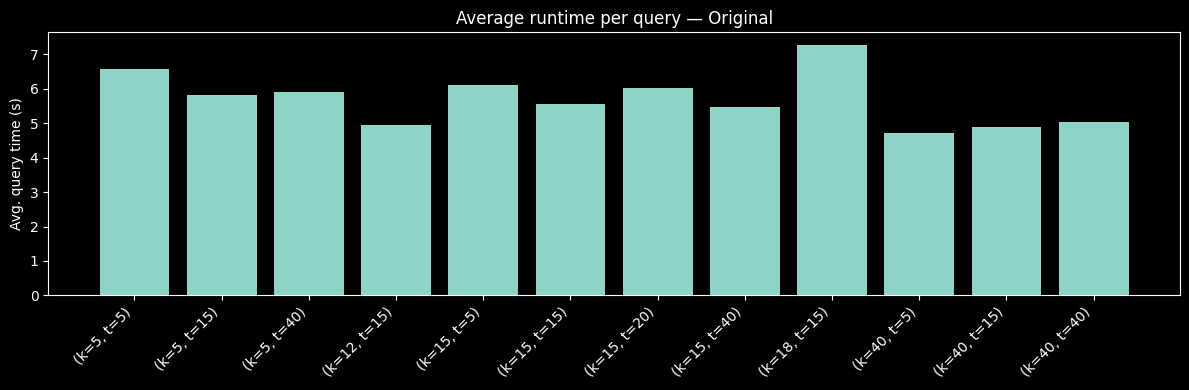

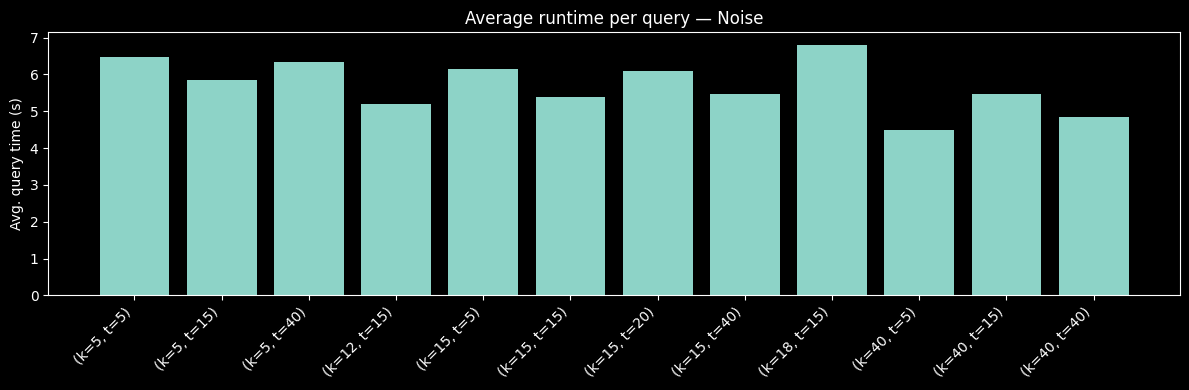

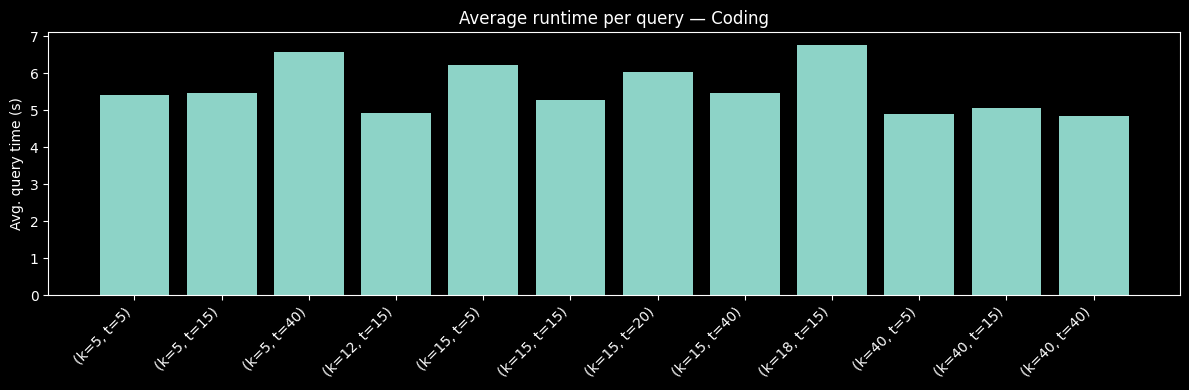

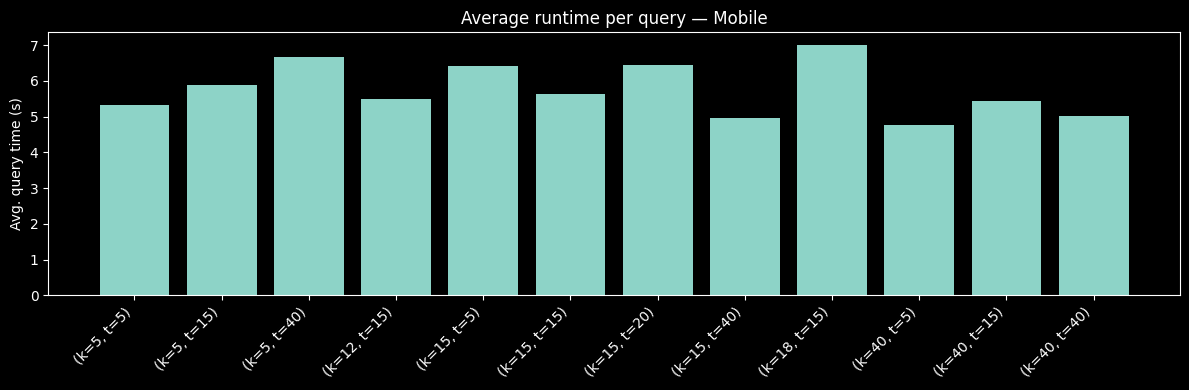

In [21]:
for dist in distortions:
    times = values_for(dist, "avg_query_time_s")
    plt.figure(figsize=(12, 4))
    plt.bar(range(len(labels)), times)
    plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
    plt.ylabel("Avg. query time (s)")
    plt.title(f"Average runtime per query — {dist}")
    plt.tight_layout()
    plt.show()

### Discussion (interpretation)

**Original / Noise / Coding.**
For these distortions, many configurations reach high accuracy. This suggests that the constellation map representation is fairly stable under moderate additive noise and coding artifacts for 10-second queries.

**Mobile recordings.**
Mobile queries were the hardest case in our dataset. Accuracy dropped substantially compared to the other distortions, and the best results tended to come from “denser” constellation maps (smaller `k`/`t`). A likely explanation is that mobile recordings introduce spectral smearing and time/frequency jitter; with sparse peak maps, too many peaks disappear or shift outside the tolerance window, reducing TP and making the match ambiguous.

**Metric choice (TP vs. F1).**
We observed that F1 often produced fewer correct identifications than TP. In this setting, peak density varies strongly between configurations: small `(k,t)` yields many peaks. F1 penalizes these maps through FP, which can reduce the match score even for the correct track. Since identification is decided by *relative ranking* across tracks, this penalty can harm separability. TP, while not fully normalized, preserved the strongest matches more reliably in our runs.

**Limitations:**
- The method is computationally expensive.
- Scores are not fully comparable across constellation map densities.
- Better indexing strategies are needed for larger databases.